In [1513]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [ ]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()




### Preprocessing delle variabili

Mapping variabile target

In [ ]:

y = np.array(pp_class['titleType'])  # Il target originale
#NON DEVO FARE ANCHE PER IL IL TEST?

# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(pp_class['titleType'].unique())}

#aggiungo una nuova colonna
pp_class['titleType_encoded'] = pp_class['titleType'].map(y_map)
## pp_test_class["titleType_encoded"] = pp_test_class['titleType'].map(y_map)

print(y_map)  # Per vedere la mappatura delle categorie

{'tvEpisode': 0, 'videoGame': 1, 'movie': 2, 'tvSeries': 3, 'video': 4, 'tvMiniSeries': 5, 'short': 6, 'tvMovie': 7, 'tvSpecial': 8, 'tvShort': 9}


##### info variabili

In [1516]:
#studio variabili (non ho messo le 28 is_genere)
pp_class[['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes', 'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits', 'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins', 'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
          #'countryOfOrigin', 
       'fill_runtimeMinutes', 'titleType_encoded']].head(3)

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,criticReviewsTotal,titleType,awardNominationsExcludeWins,canHaveEpisodes,isAdult,numRegions,userReviewsTotal,fill_runtimeMinutes,titleType_encoded
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,1995.0,NaN,0.0,779,1,0,21,1,tvEpisode,0,False,0,1,0,40.0,0
1,Looping,6,1982,1982.0,NaN,0.0,11,1,0,1,0,videoGame,0,False,0,1,0,28.0,1
2,Idealnaya para,6,1992,1992.0,NaN,0.0,38,1,0,24,0,movie,0,False,0,1,1,90.0,2


In [1517]:
pp_class.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe', 'titleType_encoded'],
      dtype='object')

gestione country of origin  -> già sul train -> codice su modifiche_test

Conversione CanHaveEpisodes in binaria 0/1

In [ ]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
##pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)

Rimuoviamo titleType dato che è già stata mappata + originaltitle e runtimeminutes non filled

In [ ]:
column2drop = ['originalTitle', 'runtimeMinutes', 'titleType']
pp_class.drop(column2drop, axis=1, inplace=True)
##pp_test_class.drop(column2drop, axis=1, inplace=True)

END YEAR-> tolto finchè non capiamo come gestirlo

In [ ]:
# Riempi i valori mancanti di 'endYear' con quelli di 'startYear' 
# -> DA VEDERE PERCHE' FATTO COME IN TEORIA HA FATTO BRUNO LASCIA COMUNQUE NAN
#pp_class['endYear'].fillna(pp_class['startYear'], inplace=True)

#OPPURE RIMUOVI
pp_class= pp_class.drop(["endYear"], axis=1)
##pp_test_class= pp_class.drop(["endYear"], axis=1)

BINARIZZAZIONE -> da capire

In [1521]:

# #binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)
#     # Alternativa: Se vuoi mantenere i valori numerici, puoi discretizzare in fasce (es. 0, 1-5, >5).
# pp_class['awardWins_bin'] = (pp_class['awardWins'] > 0).astype(int)
# pp_class['totalVideos_bin'] = (pp_class['totalVideos'] > 0).astype(int)
# pp_class['awardNominationsExcludeWins_bin'] = (pp_class['awardNominationsExcludeWins'] > 0).astype(int)


In [1522]:
#pp_class['awardNominationsExcludeWins'].value_counts().sort_index()

In [ ]:
bins_awards = [0, 1, 10, float('inf')]
labels_awards = [0, 1, 2]  # Mantengo valori numerici per compatibilità con algoritmi
pp_class['awardWins_bin'] = pd.cut(pp_class['awardWins'], bins=bins_awards, labels=labels_awards, right=False)
## pp_test_class['awardWins_bin'] = pd.cut(pp_test_class['awardWins'], bins=bins_awards, labels=labels_awards, right=False)



bins_videos = [0, 1, 6, float('inf')]
labels_videos = [0, 1, 2]
pp_class['totalVideos_bin'] = pd.cut(pp_class['totalVideos'], bins=bins_videos, labels=labels_videos, right=False)
## pp_test_class['totalVideos_bin'] = pd.cut(pp_test_class['totalVideos'], bins=bins_videos, labels=labels_videos, right=False)



bins_nom = [0, 1, 5, float('inf')]
labels_nom = [0, 1, 2]
pp_class['awardNominationsExcludeWins_bin'] = pd.cut(pp_class['awardNominationsExcludeWins'], 
                                                    bins=bins_nom, 
                                                    labels=labels_nom, 
                                                    right=False)
## pp_train_class['awardNominationsExcludeWins_bin'] = pd.cut(pp_train_class['awardNominationsExcludeWins'], 
#                                                    bins=bins_nom, 
#                                                    labels=labels_nom, 
#                                                    right=False)



# Assicurati che le nuove colonne siano di tipo numerico
pp_class['awardWins_bin'] = pp_class['awardWins_bin'].astype(int)
pp_class['totalVideos_bin'] = pp_class['totalVideos_bin'].astype(int)
pp_class['awardNominationsExcludeWins_bin'] = pp_class['awardNominationsExcludeWins_bin'].astype(int)

## pp_test_class['awardWins_bin'] = pp_test_class['awardWins_bin'].astype(int)
## pp_test_class['totalVideos_bin'] = pp_test_class['totalVideos_bin'].astype(int)
## pp_test_class['awardNominationsExcludeWins_bin'] = pp_test_class['awardNominationsExcludeWins_bin'].astype(int)


### --> Filtra dataset su classi meno rappresentate 
##### gaia-> "videoGame":1, "tvMiniSeries": 5, "tvSpecial":8, "tvShort":9

In [ ]:
pp_class = pp_class[~pp_class['titleType_encoded'].isin([7,8, 9])]
## pp_test_class = pp_test_class[~pp_test_class['titleType_encoded'].isin([7,8, 9])]

Encoding di titletype per multiclass classification task

In [ ]:
# Extract target (y)
y_train = pp_class["titleType_encoded"].values  # Convert directly to NumPy
## y_test = pp_test_class["titleType_encoded"].values  # Convert directly to NumPy

####  creazione array di valori -> da cui scegliere feature da usare

In [ ]:
#X_train = pp_class.values
X_train = pp_class[[
       #'rating', #cambia poco
       'startYear',  #forse lasciare, sempre 77a ma aiuta a classificare una classe in + 
       'numVotes', 
       #'totalImages', eggiora poco
       'totalCredits', 
       'criticReviewsTotal',
       'canHaveEpisodes', 
       #'isAdult', peggiora molto
       #'numRegions', 
       'userReviewsTotal', 
       #'endYear',
       #'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery',  'is_Talk-Show', 'is_Drama', 'is_Sport', 'is_War', 'is_Horror','is_Animation', 
       'fill_runtimeMinutes', #da tenere
       #'is_from_Oceania','is_from_North America', 'is_from_South America', 'is_from_Asia', 'is_from_Africa', 'is_from_Europe', 
       #'awardWins_bin',  'totalVideos_bin', 'awardNominationsExcludeWins_bin'
       ]].values

## X_test = pp_test_class[[ ]].values

### Splitting in validation 
##### -> penso su y_train (array valori multilabeled)

In [1527]:


X_train2, X_val, y_train2, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=32
)


# X_train2 = training set --> 80% di X_train
# X_val = validation set --> 20% di X_train
# y_train2 e y_val sono i target corrispondenti (etichette) per i dati di addestramento e validazione

### Normalization

In [ ]:
X_train2_log = np.log1p(X_train2)
X_val_log= np.log1p(X_val)

## X_train_log = np.log1p(X_train)
## X_test_log = np.log1p(X_test)

In [ ]:

standardsc = StandardScaler()

        # # Fitta e trasforma il training set in un solo passaggio
X_train2_standardsc = standardsc.fit_transform(X_train2_log)
X_val_standardsc = standardsc.fit_transform(X_val_log)

## X_train_standardsc = standardsc.fit_transform(X_train_log)
        # # Trasforma il test set (senza rifittare!)
## X_test_standardsc = standardsc.transform(X_test_log)

In [ ]:
# minmax = MinMaxScaler()

        ## Fitta e trasforma il training set in un solo passaggio
# X_train2_minmax = minmax.fit_transform(X_train2_log)
# X_val_minmax = minmax.fit_transform(X_val_log)

## X_train_minmax = minmax.fit_transform(X_train_log)
        # # Trasforma il test set (senza rifittare!)
# #X_test_minmax = minmax.transform(X_test)



In [ ]:
X_train2_tr = X_train2_standardsc
X_val_tr = X_val_standardsc

## X_train_tr = X_train_standardsc
## X_test_tr = X_test_standardsc

## NAIVE BAYES

In [1532]:
clf = GaussianNB()

In [1533]:
clf.fit(X_train2_tr, y_train2)

GaussianNB()

Predicting on validation set

In [1534]:
y_pred = clf.predict(X_val_tr)
y_pred

array([0, 6, 0, ..., 6, 4, 2], dtype=int64)

In [1535]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3072
3072


In [1536]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4, 5, 6}


In [1537]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.8134765625

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       959
           1       0.86      0.49      0.62        61
           2       0.87      0.85      0.86      1097
           3       0.89      0.97      0.93       272
           4       0.37      0.33      0.35       155
           5       0.31      0.11      0.17        35
           6       0.84      0.82      0.83       493

    accuracy                           0.81      3072
   macro avg       0.70      0.63      0.65      3072
weighted avg       0.81      0.81      0.81      3072



0 in precision recall e f1-score = il modello non è riuscito a identificare correttamente nessun esempio di queste classi-> prob sta predicendo altre classi per questi esemp

{'tvEpisode': 0,  'movie': 2, 'tvSeries': 3, 'video': 4,  'short': 6, 'tvMovie': 7, }
tolti -> 'videoGame': 1, 'tvMiniSeries': 5,'tvSpecial': 8, 'tvShort': 9

In [1538]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[7.25839135e-001, 1.77573609e-060, 6.25658368e-002, ...,
        1.99195828e-001, 0.00000000e+000, 1.23992001e-002],
       [5.40014206e-004, 3.41392325e-144, 2.90509572e-025, ...,
        4.60692766e-006, 0.00000000e+000, 9.99455379e-001],
       [4.32597246e-001, 7.38430831e-002, 1.89941002e-006, ...,
        6.76943857e-002, 0.00000000e+000, 4.25863386e-001],
       ...,
       [5.36159796e-004, 4.93570251e-172, 2.29719721e-028, ...,
        3.68414550e-002, 0.00000000e+000, 9.62622385e-001],
       [1.17731421e-001, 2.64692603e-177, 4.34963741e-001, ...,
        4.45813707e-001, 0.00000000e+000, 1.49113090e-003],
       [2.02198057e-001, 8.85912750e-189, 7.74143745e-001, ...,
        2.30426407e-002, 0.00000000e+000, 6.15556661e-004]])

roc test

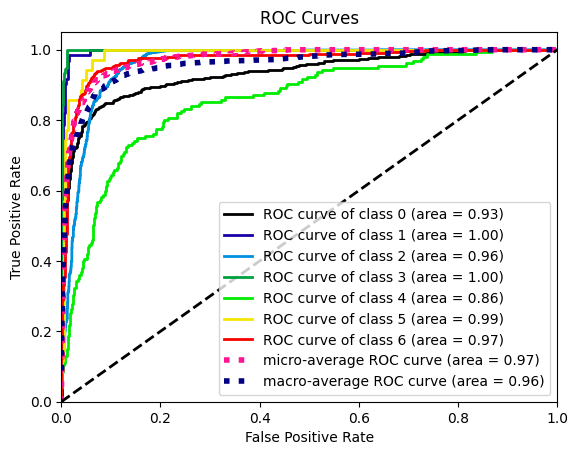

0.9579499664002541


In [1539]:
plot_roc(y_val, clf.predict_proba(X_val_tr))
plt.show()
print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

Distribuzioni classi nel train set

In [1540]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    3739
1     198
2    4438
3    1103
4     637
5     189
6    1981
Name: count, dtype: int64


confusion matrix 

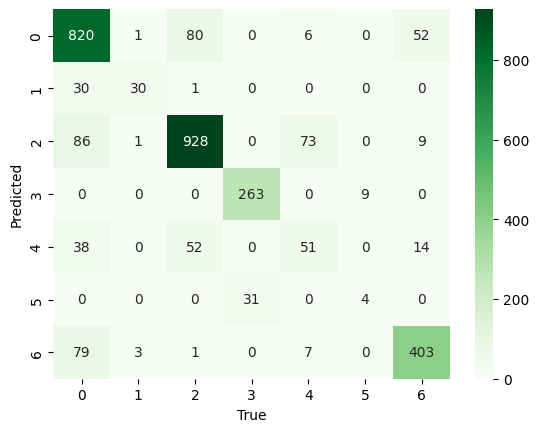

In [1541]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

Verifica overfitting

Performance sul Training set:
Accuracy: 0.8155
F1 Score: 0.8102

Performance sul Validation set:
Accuracy: 0.8135
F1 Score: 0.8089


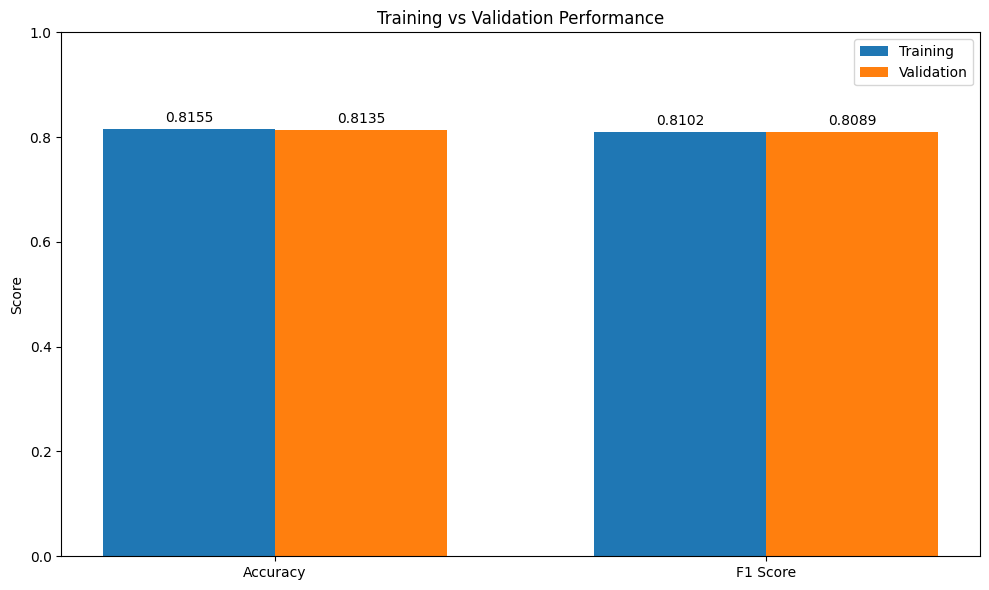

In [1542]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

## Proper testing on the test set

In [ ]:
##clf = GaussianNB()
##clf.fit(X_train_tr, y_train)
## y_tpred = clf.predict(X_test_tr)
## y_tpred

In [ ]:
# # Importazioni necessarie (se non già importate)
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns

# # Valutazione sul training set
# y_pred_train = clf.predict(X_train_tr)
# train_accuracy = accuracy_score(y_train, y_pred_train)
# train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# # Valutazione sul validation set
# y_pred_test = clf.predict(X_test_tr)
# test_accuracy = accuracy_score(y_test, y_pred_test)
# test_f1 = f1_score(y_test, y_pred_test, average='weighted')
#                         ### gaia ha messo y_tpred

# # Stampa dei risultati
# print(f"Performance sul Training set:")
# print(f"Accuracy: {train_accuracy:.4f}")
# print(f"F1 Score: {train_f1:.4f}")
# print("\nPerformance sul test set:")
# print(f"Accuracy: {test_accuracy:.4f}")
# print(f"F1 Score: {test_f1:.4f}")

# # Visualizzazione grafica del confronto
# metrics = ['Accuracy', 'F1 Score']
# train_scores = [train_accuracy, train_f1]
# test_scores = [test_accuracy, test_f1]

# x = np.arange(len(metrics))
# width = 0.35

# fig, ax = plt.subplots(figsize=(10, 6))
# rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
# rects2 = ax.bar(x + width/2, test_scores, width, label='Validation')

# ax.set_ylabel('Score')
# ax.set_title('Training vs Validation Performance')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics)
# ax.legend()
# ax.set_ylim(0, 1)

# # Aggiungi i valori sopra le barre
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate(f'{height:.4f}',
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)

# plt.tight_layout()
# plt.show()